# $\lambda$ Experiments


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import copy

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines, stochastic_hamming_loss
from crm_dataset import CRMDataset
from crm_model import Model

---
### Loading dataset

In [7]:
dataset_name='scene'
# dataset_name='yeast'
# dataset_name='tmc2007'

X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name, reduce_dim=200)

reducing dimension for TMC dataset
X_train: (1805, 200) y_train: (1805, 6)


### Baselines & Skylines

In [8]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train, n_jobs=4)

# The Experiment

In [9]:
len(X_train)

1805

In [10]:
n_rollouts = 10

samples = [len(X_train)]
for _ in range(n_rollouts):
    samples += [int(samples[-1] / 2)]
samples = sorted([_ for _ in samples if _ > 100])

n_replays = 6  # actions per context
n_reruns = 5 # to account for action stochasticity

samples

[112, 225, 451, 902, 1805]

In [11]:
lambda_grid = [1e-4, 1e-3, 1e-2, 1e-1, .25, .5, .75, 1, 10, 100, 0, -1e-4, -1e-3, -1e-2, -1e-1, -.25, -.5, -.75, -1, -10, 100

In [12]:
crm_loss_by_lambda = []
crm_reward_by_lambda = []

test_sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T
crm_reward = CRMDataset().update_from_supervised_dataset(
    X_test, y_test, test_sampling_probas, n_samples=4
).rewards.sum() / (len(X_test)*y_test.shape[1]*4)


for lambda_ in lambda_grid:
        
    crm_losses = np.ones((n_reruns, len(samples)))
    crm_rewards = np.ones((n_reruns, len(samples)))

    for i in range(n_reruns):
        np.random.seed(i*42+1000)
        print(i, end='')

        crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
        crm_dataset = CRMDataset()

        start = 0
        for j, end in enumerate(samples):
            print('.', end='')
            # current batch
            X = X_train[start:end, :]
            y = y_train[start:end, :]
            if end > start:
                # CRM play & data collection
                sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X)]).T 
                crm_dataset.update_from_supervised_dataset(X, y, sampling_probas, n_samples=n_replays)
                # learning
                crm_model.fit(
                    crm_dataset, 
                    lambda_ = lambda_,
                    verbose = 0
                )
            # eval
            crm_losses[i,j] = crm_model.expected_hamming_loss(X_test, y_test)
            crm_rewards[i,j] = crm_reward * len(X)
            # next round
            start = end
        print()

    crm_loss_by_lambda += [crm_losses.mean(axis=0)[-1]]
    crm_reward_by_lambda += [crm_rewards.mean(axis=0).sum()]
    print("Lambda:", lambda_, "final loss:", crm_loss_by_lambda[-1], "cum reward:", crm_reward_by_lambda[-1])

0.....
1.....
2.....
3.....
4.....
Lambda: 0.0001 final loss: 0.18253632738175626 cum reward: 1440.202104097453
0.....
1.....
2.....
3.....
4.....
Lambda: 0.001 final loss: 0.18254565704288145 cum reward: 1440.202104097453
0.....
1.....
2.....
3.....
4.....
Lambda: 0.01 final loss: 0.1842136983182524 cum reward: 1440.202104097453
0.....
1.....
2.....
3.....
4.....
Lambda: 0.1 final loss: 0.1846254167323113 cum reward: 1440.202104097453
0.....
1.....
2.....
3.....
4.....
Lambda: 1 final loss: 0.1793686961703312 cum reward: 1440.202104097453
0.....
1.....
2.....
3.....
4.....
Lambda: 10 final loss: 0.2664033233095096 cum reward: 1440.202104097453
0.....
1.....
2.....
3.....
4.....
Lambda: 100 final loss: 0.5319857724645707 cum reward: 1440.202104097453


In [13]:
scrm_loss_by_lambda = []
scrm_reward_by_lambda = []

for lambda_ in lambda_grid:

    scrm_losses = np.ones((n_reruns, len(samples)))
    scrm_rewards = np.ones((n_reruns, len(samples)))

    for i in range(n_reruns):
        np.random.seed(i*42+1000)
        print(i, end='')

        scrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
        scrm_dataset = CRMDataset()

        start = 0
        for j, end in enumerate(samples):
            print('.', end='')
            # current batch
            X = X_train[start:end, :]
            y = y_train[start:end, :]
            if end > start:
                # CRM play & data collection
                if j == 0:
                    sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X)]).T 
                else:
                    sampling_probas = scrm_model.predict_proba(X, y)
                scrm_dataset.update_from_supervised_dataset(X, y, sampling_probas, n_samples=n_replays)
                # learning
                scrm_model.fit(
                    scrm_dataset, 
                    lambda_ = lambda_,
                    verbose = 0
                )
            # eval
            scrm_losses[i,j] = scrm_model.expected_hamming_loss(X_test, y_test)
            scrm_rewards[i,j] = CRMDataset().update_from_supervised_dataset(
                X_test, y_test, scrm_model.predict_proba(X_test, np.ones_like(y_test)), n_samples=4
            ).rewards.sum()  / (len(X_test)*y_test.shape[1]*4) * len(X)
            # next round
            start = end
        print()

    scrm_loss_by_lambda += [scrm_losses.mean(axis=0)[-1]]
    scrm_reward_by_lambda += [scrm_rewards.mean(axis=0).sum()]
    print("Lambda:", lambda_, "final loss:", scrm_loss_by_lambda[-1], "cum reward:", scrm_reward_by_lambda[-1])
    

0.....
1.....
2.....
3.....
4.....
Lambda: 0.0001 final loss: 0.3397427917147925 cum reward: 1183.0011904761905
0.....
1.....
2.....
3.....
4.....
Lambda: 0.001 final loss: 0.334783075422005 cum reward: 1186.3794296788483
0.....
1.....
2.....
3.....
4.....
Lambda: 0.01 final loss: 0.3183538938275493 cum reward: 1201.4423172757474
0.....
1.....
2.....
3.....
4.....
Lambda: 0.1 final loss: 0.3437457478708732 cum reward: 1161.0770625692137
0.....
1.....
2.....
3.....
4.....
Lambda: 1 final loss: 0.3918764085531122 cum reward: 1036.1321290143965
0.....
1.....
2.....
3.....
4.....
Lambda: 10 final loss: 0.4577705112715316 cum reward: 940.6007336655591
0.....
1.....
2.....
3.....
4.....
Lambda: 100 final loss: 0.5584068584860701 cum reward: 727.537361572536


In [14]:
baseline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T, n_samples=4
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
for _ in range(n_reruns)])
baseline_rewards = np.ones_like(lambda_grid) * baseline_reward * samples[-1]

skyline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        np.array([_[:,1] for _ in pistar.predict_proba(X_test)]).T, n_samples=4
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
for _ in range(n_reruns)])
skyline_rewards = np.ones_like(lambda_grid) * skyline_reward * samples[-1]

map_skyline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        pistar.predict(X_test), n_samples=1
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*1)
for _ in range(n_reruns)])
map_skyline_rewards = map_skyline_reward * samples[-1]

baseline_loss = np.ones_like(lambda_grid)*stochastic_hamming_loss(pi0, X_test, y_test)
skyline_loss = np.ones_like(lambda_grid)*stochastic_hamming_loss(pistar, X_test, y_test)

/home/e.diemert/miniconda/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [15]:
pd.DataFrame(data={
    'lambda': lambda_grid,
    'baseline': baseline_loss,
    'CRM': crm_loss_by_lambda,
    'S-CRM': scrm_loss_by_lambda,
    'skyline': skyline_loss,
}).to_latex('loss_by_lambda-%s.tex' % dataset_name, index=False)

pd.DataFrame(data={
    'lambda': lambda_grid,
    'baseline': baseline_rewards,
    'CRM': crm_reward_by_lambda,
    'S-CRM': scrm_reward_by_lambda,
    'skyline': skyline_rewards,
}).to_latex('cumreward_by_lambda-%s.tex' % dataset_name, index=False)

/tmp/ipykernel_51011/3500174032.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(data={
/tmp/ipykernel_51011/3500174032.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  pd.DataFrame(data={


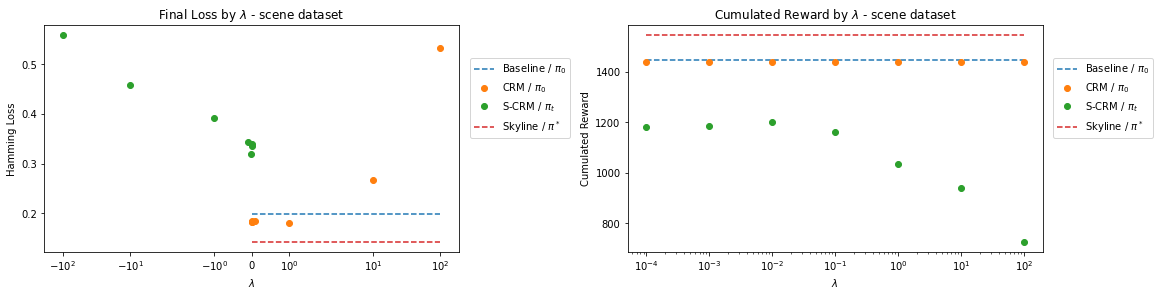

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(16,4))

ax1.set_title('Final Loss by $\lambda$ - %s dataset' % dataset_name)
ax1.set_xlabel('$\lambda$')
ax1.set_xscale('symlog')
ax1.plot(lambda_grid, baseline_loss, '--', label='Baseline / $\pi_0$')
ax1.plot(lambda_grid, crm_loss_by_lambda, 'o', label='CRM / $\pi_0$')
ax1.plot(np.array(lambda_grid)*-1, scrm_loss_by_lambda, 'o', label='S-CRM / $\pi_t$')
ax1.plot(lambda_grid, skyline_loss, '--', label='Skyline / $\pi^*$')
ax1.set_ylabel('Hamming Loss')
ax1.legend(loc=(1.025, .5))

ax2.set_title('Cumulated Reward by $\lambda$ - %s dataset' % dataset_name)
ax2.set_xlabel('$\lambda$')
ax2.plot(lambda_grid, baseline_rewards, '--', label='Baseline / $\pi_0$')
ax2.plot(lambda_grid, crm_reward_by_lambda, 'o', label='CRM / $\pi_0$')
ax2.plot(lambda_grid, scrm_reward_by_lambda, 'o', label='S-CRM / $\pi_t$')
ax2.plot(lambda_grid, skyline_rewards, '--', label='Skyline / $\pi^*$')
ax2.set_xscale('log')
ax2.set_ylabel('Cumulated Reward')
ax2.legend(loc=(1.025, .5))

plt.savefig('lambda_grid-%s.png' % dataset_name)